In [1]:
# main file that includes all relevant sph functionality
from sph import *

# main file that includes all learning relevant functionality, not necessary to understand
from torch.optim import Adam
from rbfConv import *
from torch_geometric.loader import DataLoader
from trainingHelper import *
# plotting/UI related imports
import matplotlib as mpl
plt.style.use('dark_background')
cmap = mpl.colormaps['viridis']
from tqdm.notebook import trange, tqdm
from IPython.display import display, Latex
%matplotlib notebook

In [2]:
numParticles = 2048 # set up here as PDF sampling and noise functions use this parameter

# different initial starting conditions, just pick one
# sinusoidal sampling
# pdf = lambda x: np.sin(x * np.pi * 4) + 2
# (excessive) sawtooth profile with step at x = 1 that has 0 density at x=-1 (barring periodic BC)
# pdf = lambda x: 1 + x
# square wave sampling
def pdf(x):
    out = np.array(np.ones_like(x) * 2)
    out[np.abs(x) > 1/3] = 1
    return out
# sawtooth profile with step at x = 1 with at least a density of 1 everywhere
# def pdf(x):
#     x = np.array(x)
#     out = np.array(np.ones_like(x))
#     out[x > 0] = x[x>0] + 0
#     out[x < 0] = x[x<0] + 2
#     return out + 1
# triangular density profile with peaks at x=-1 and x=1
# pdf = lambda x: np.abs(x) + 1
# gaussian density profile with narrow peak
# pdf = lambda x: 1 + np.exp(-(x * 8)**2) * 2
# uniform density profile, mostly for debugging
# pdf = lambda x: np.ones_like(np.array(x))
# octave noise based on perlin noise
# noise  = 2 + generate1DPeriodicNoise(numSamples = numParticles, r = 0.75, freq = 1, octaves = 4, plot = False, seed = 1234) * 0.25
# pdf = lambda x : np.interp(x, np.linspace(-1,1,numParticles), noise)
# low frequency sinusoidal sampling,  mostly to test the interp process
# noise = 2 + np.sin(np.linspace(-np.pi, np.pi, numParticles))
# pdf = lambda x : np.interp(x, np.linspace(-1,1,numParticles), noise)

In [259]:
def computeLaminarViscosity(i, j, ri, rj, Vi, Vj, distances, radialDistances, support, numParticles : int, eps : float, rhoi, rhoj, ui, uj, alpha : float, beta: float, c0 : float, restDensity : float):
    gradW = kernelGradient(radialDistances, distances, support)

    uij = ui[i] - uj[j]
    rij = ri[i] - rj[j]
    rij = -distances * radialDistances
    
    mu_nom = support * (uij * rij)
    mu_denom = torch.abs(rij) + 0.01 * support**2
    mu = mu_nom / mu_denom
    
    
    nom = - alpha * c0 * mu + beta * mu**2
    denom = (rhoi[i] + rhoj[j]) / 2
    termL = Vi[j] * nom / denom
#     rab = rij / mu_denom    
    
    term = termL * gradW# * torch.sign(ri[j] - ri[i] + 0.01 * support **2)
#     term = alpha * 2 * Vj[j] / rhoj[j] * torch.abs(gradW) / rij2
    

#     xsphUpdate = scatter(pairwiseXSPH, fluidNeighbors[0], dim=0, dim_size = fluidPositions.shape[0],reduce='add')
    return scatter(term, i, dim=0, dim_size = Vi.shape[0], reduce='add')


def computeDiffusion(fluidPositions, fluidVelocities, fluidAreas, fluidDensities, particleSupport, restDensity, alpha, beta, c0, fluidNeighbors, fluidRadialDistances, fluidDistances):
    laminarViscosity = computeLaminarViscosity(fluidNeighbors[0], fluidNeighbors[1], \
                                                                                      fluidPositions, fluidPositions, fluidAreas, fluidAreas,\
                                                                                      fluidDistances, fluidRadialDistances,\
                                                                                      particleSupport, fluidDensities.shape[0], 1e-7,\
                                                                                      fluidDensities, fluidDensities,\
                                                                                      fluidVelocities,fluidVelocities,
                                                                                      alpha, beta, c0, restDensity)
    
    return laminarViscosity

In [260]:
ghostPositions = createGhostParticles(fluidPositions, minDomain, maxDomain)
#  2. Find neighborhoods of all particles:
fluidNeighbors, fluidRadialDistances, fluidDistances = findNeighborhoods(fluidPositions, ghostPositions, particleSupport)

fluidDistances

tensor([-1., -1., -1.,  ..., -1., -1., -1.], dtype=torch.float64)

In [261]:
particleSupport * 1 / 5 * 700

1.09375

In [262]:
# SPH simulation step, returns dudt, dxdt as well as current density and pressure
def computeUpdate(fluidPositions, fluidVelocities, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphCoefficient, particleSupport, dt):
    #  1. Create ghost particles for our boundary conditions
    ghostPositions = createGhostParticles(fluidPositions, minDomain, maxDomain)
    #  2. Find neighborhoods of all particles:
    fluidNeighbors, fluidRadialDistances, fluidDistances = findNeighborhoods(fluidPositions, ghostPositions, particleSupport)
    #  3. Compute \rho using an SPH interpolation
    fluidDensity = computeDensity(fluidPositions, fluidAreas, particleSupport, fluidRadialDistances, fluidNeighbors)
    #  4. Compute the pressure of each particle using an ideal gas EOS
    fluidPressure = (fluidDensity - 1.0) * kappa * restDensity
    #  5. Compute the XSPH term and apply it to the particle velocities:    
    xsphUpdate = computeXSPH(fluidPositions, fluidVelocities, fluidDensity, fluidAreas, particleSupport, xsphCoefficient, fluidNeighbors, fluidRadialDistances)
    #  6. Compute pressure forces and resulting acceleration
    fluidPressureForces = computePressureForces(fluidPositions, fluidDensity, fluidPressure, fluidAreas, particleSupport, restDensity, fluidNeighbors, fluidRadialDistances, fluidDistances)
    fluidAccel = fluidPressureForces # / (fluidAreas * restDensity)
    # 7. Compute kinematic viscosity
    laminarViscosity = computeDiffusion(fluidPositions, fluidVelocities, fluidAreas, fluidDensity, particleSupport, restDensity, diffusionAlpha, diffusionBeta, c0, fluidNeighbors, fluidRadialDistances, fluidDistances) # currently broken for some reason
#     fluidAccel += laminarViscosity
    fluidAccel += xsphUpdate / dt + laminarViscosity
    return fluidAccel, fluidVelocities, fluidDensity, fluidPressure

In [263]:
# simulation parameters
minDomain = -1 # minimum domain, leave at -1 for the most part
maxDomain = 1 # maximum domain, leave at 1 for the most part
# change base area to change initial starting density
baseArea = 2 / numParticles * 2
particleRadius = baseArea / 2.0
# change particle support to make simulation more/less smooth
particleSupport = particleRadius * 8.
# SPH parameters
xsphConstant = 0.0
diffusionAlpha = 1. # kinematic viscosity coefficient
diffusionBeta = 2.
kappa = 10 # EOS kappa term
restDensity = 1000 # EOS rest density term
dt = 1e-3 # fixed global timestep
c0 = 100 # speed of sound used in kinematic viscosity

timesteps = 2048 # timesteps to be simulated
display(Latex(f'Estimated kinematic diffusion $\\mu\\approx\\frac{{1}}{{2(d+2)}}\\alpha c_s h = \\frac{{1}}{{2(1+2)}} \\cdot {diffusionAlpha} \\cdot {c0} \\cdot {particleSupport} = {1/6 * diffusionAlpha * c0 * particleSupport}$'))
# display(Latex(f'Estimated kinematic diffusion ? $\\zeta\approx\\frac{{5}}{{6(d+2)}}\\alpha c_s h = \\frac{{1}}{{2(1+2)}} \\cdot {diffusionAlpha} \\cdot {c0} \\cdot {particleSupport} = {1/6 * diffusionAlpha * c0 * particleSupport}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


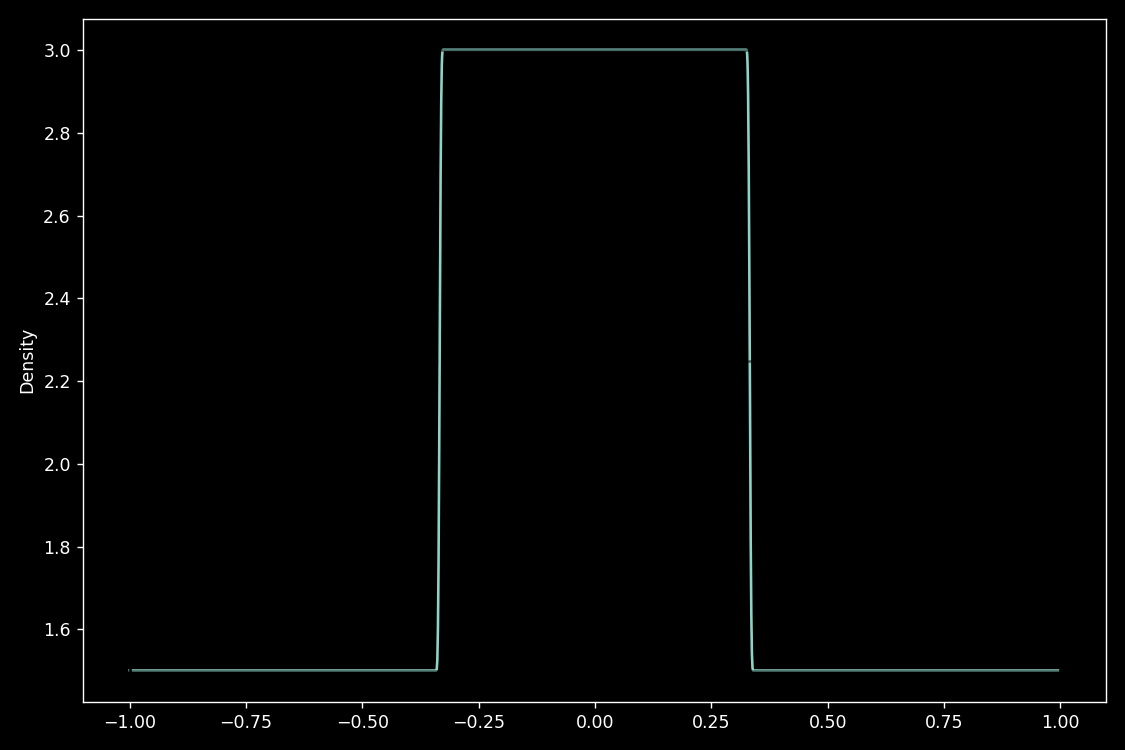

In [264]:
# sample the pdf using the inverse CFD, plotting shows the pdf
sampled = samplePDF(pdf, plot = False, numParticles = numParticles)
# sample positions according to the given pdf
fluidPositions = ((torch.tensor(sampled)/2 +0.5)* (maxDomain - minDomain) + minDomain)
# initially zero velocity everywhere
fluidVelocities = torch.zeros(fluidPositions.shape[0])
# and all particles with identical masses
fluidAreas = torch.ones_like(fluidPositions) * baseArea
# simulationStates holds all timestep information
simulationStates = []
# plot initial density field to show starting conditions
plotDensity(fluidPositions, fluidAreas, minDomain, maxDomain, particleSupport)

In [266]:
# run the simulation using RK4
for i in tqdm(range(timesteps)):
    # Compute state for substep 1
    v1 = torch.clone(fluidVelocities)
    # RK4 substep 1
    dudt_k1, dxdt_k1, fluidDensity, fluidPressure = computeUpdate(fluidPositions, fluidVelocities, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphConstant, particleSupport, dt)   
    # Compute state for substep 2
    x_k1 = fluidPositions + 0.5 * dt * dxdt_k1
    x_k1[x_k1 < minDomain] += maxDomain - minDomain
    x_k1[x_k1 > maxDomain] -= maxDomain - minDomain    
    u_k1 = fluidVelocities + 0.5 * dt * dudt_k1    
    # RK4 substep 2
    dudt_k2, dxdt_k2, _, _ = computeUpdate(x_k1, u_k1, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphConstant, particleSupport, 0.5 * dt)    
    # Compute state for substep 2
    x_k2 = fluidPositions + 0.5 * dt * dxdt_k2
    x_k2[x_k2 < minDomain] += maxDomain - minDomain
    x_k2[x_k2 > maxDomain] -= maxDomain - minDomain
    u_k2 = fluidVelocities + 0.5 * dt * dudt_k2
    # RK4 substep 3
    dudt_k3, dxdt_k3, _, _ = computeUpdate(x_k2, u_k2, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphConstant, particleSupport,  0.5 * dt)    
    # Compute state for substep 4    
    x_k3 = fluidPositions + dt * dxdt_k3
    x_k3[x_k3 < minDomain] += maxDomain - minDomain
    x_k3[x_k3 > maxDomain] -= maxDomain - minDomain
    u_k3 = fluidVelocities + dt * dudt_k3
    # RK4 substep 4
    dudt_k4, dxdt_k4, _, _ = computeUpdate(x_k3, u_k3, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphConstant, particleSupport, dt)    
    # RK substeps done, store current simulation state for later processing/learning. density and pressure are based on substep 1 (i.e., the starting point for this timestep)
    simulationStates.append(torch.stack([fluidPositions, fluidVelocities, fluidDensity, fluidPressure, dt/6 * (dudt_k1 + 2* dudt_k2 + 2 * dudt_k3 + dudt_k4), fluidAreas]))
    # time integration using RK4 for velocity
    fluidVelocities = fluidVelocities + dt/6 * (dudt_k1 + 2* dudt_k2 + 2 * dudt_k3 + dudt_k4)
    fluidPositions = fluidPositions + dt * fluidVelocities
    # enforce periodic boundary conditions
    fluidPositions[fluidPositions < minDomain] += maxDomain - minDomain
    fluidPositions[fluidPositions > maxDomain] -= maxDomain - minDomain
# After the simulation has run we stack all the states into one large array for easier slicing and analysis
simulationStates = torch.stack(simulationStates)

  0%|          | 0/2048 [00:00<?, ?it/s]

In [267]:

# plotSimulationState(simulationStates, minDomain, maxDomain, dt, timepoints = 180 + np.array([0, 1,2,3,4,5,6,7,8,9,10]))

<IPython.core.display.Javascript object>


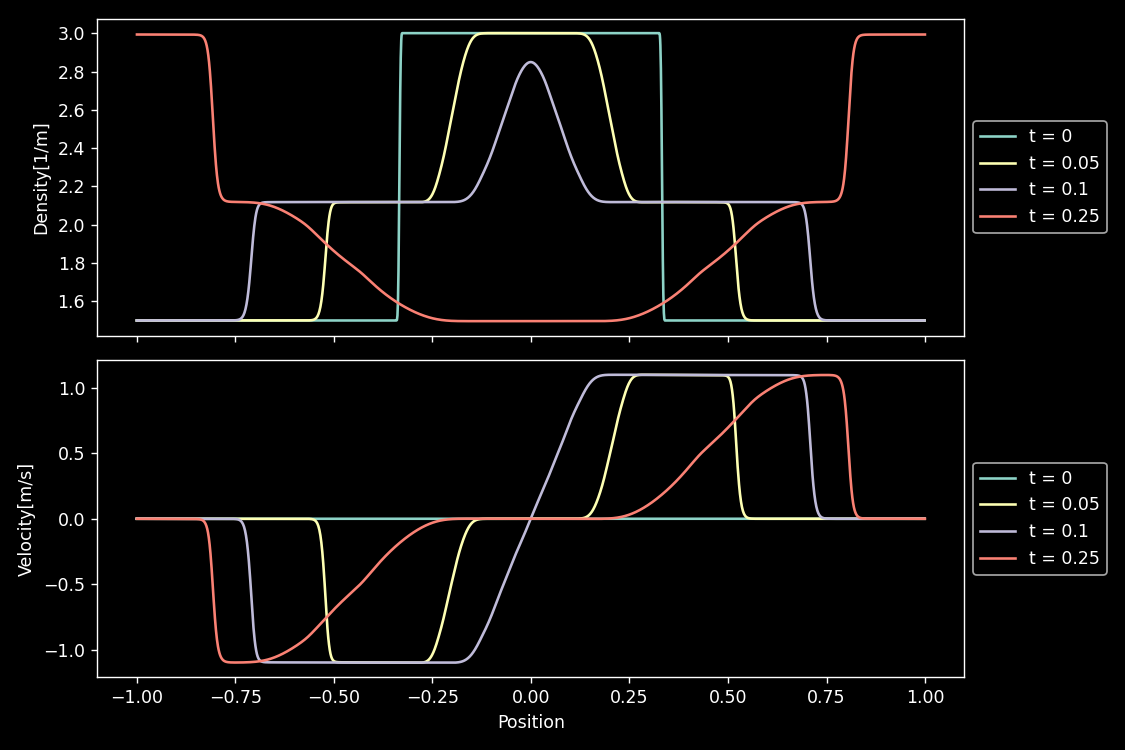

<IPython.core.display.Javascript object>


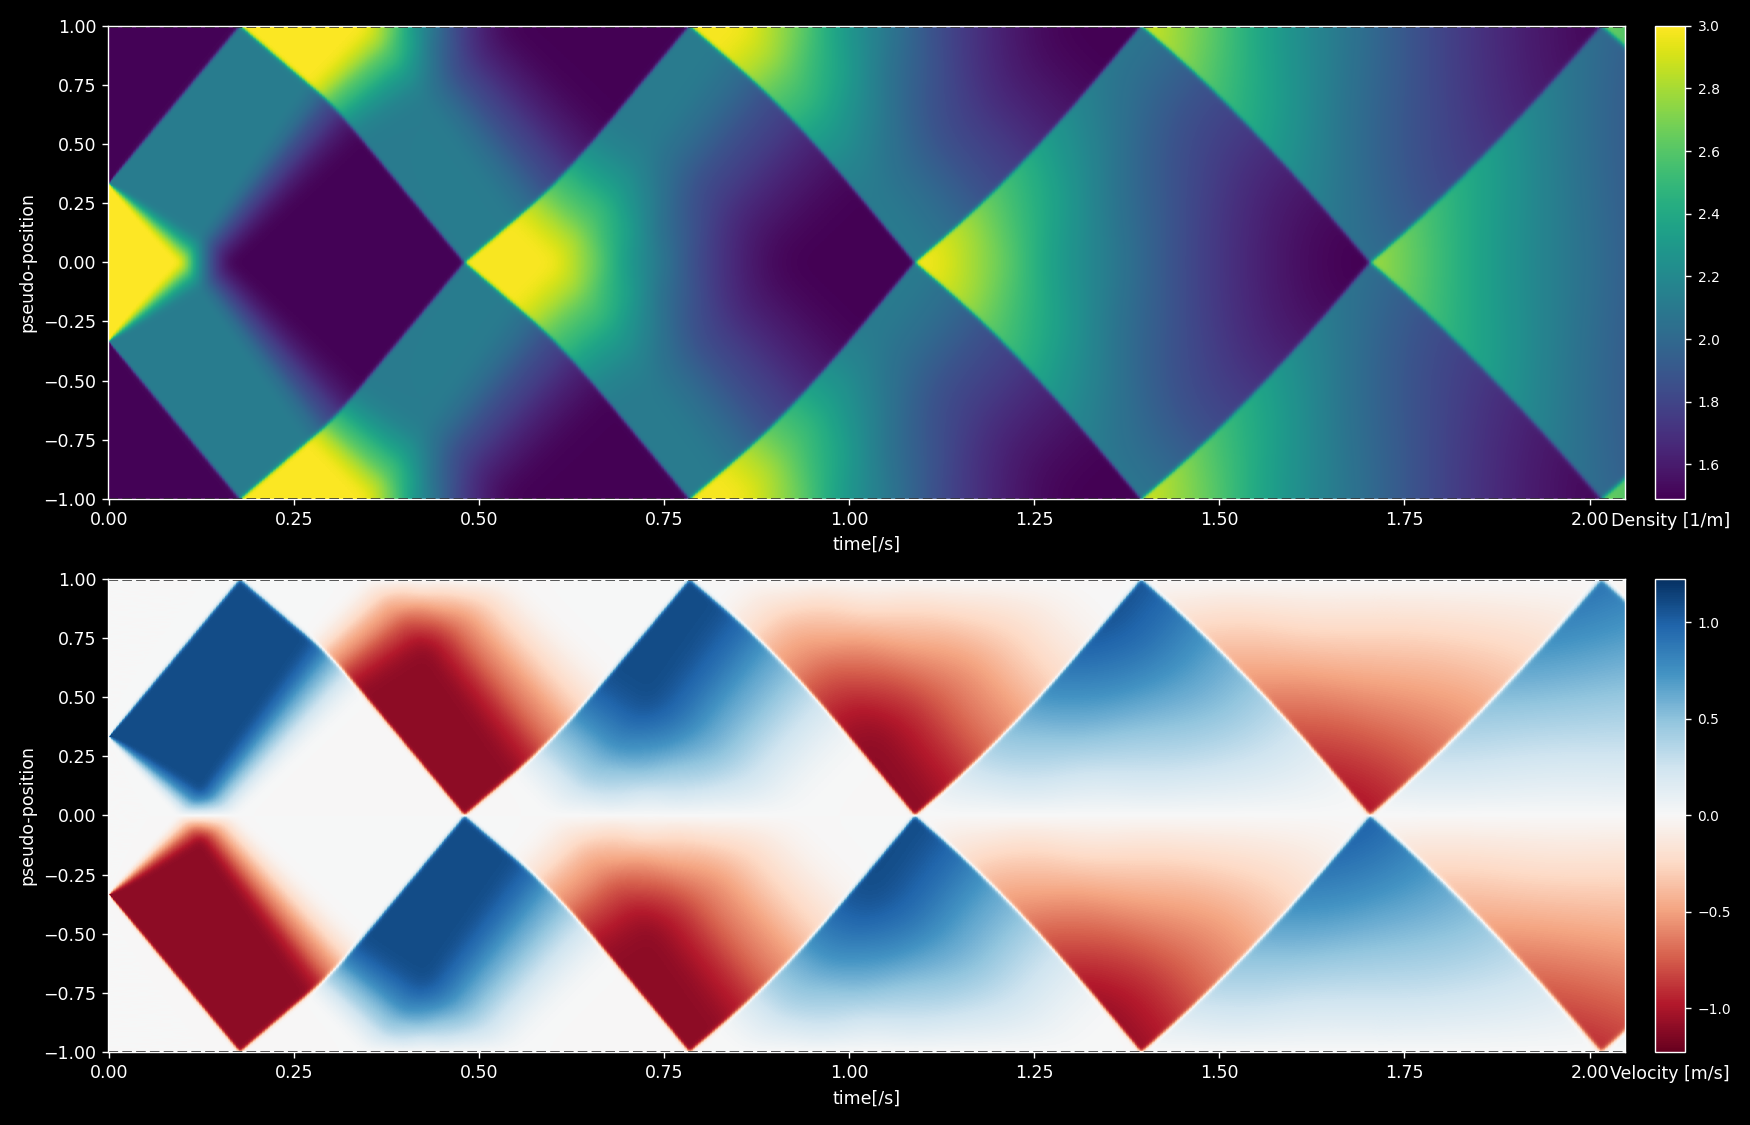

In [268]:

plotSimulationState(simulationStates, minDomain, maxDomain, dt, timepoints = [0, 50, 100, 250])
regularPlot(simulationStates, minDomain, maxDomain, dt, nx = numParticles, ny = timesteps)

<IPython.core.display.Javascript object>


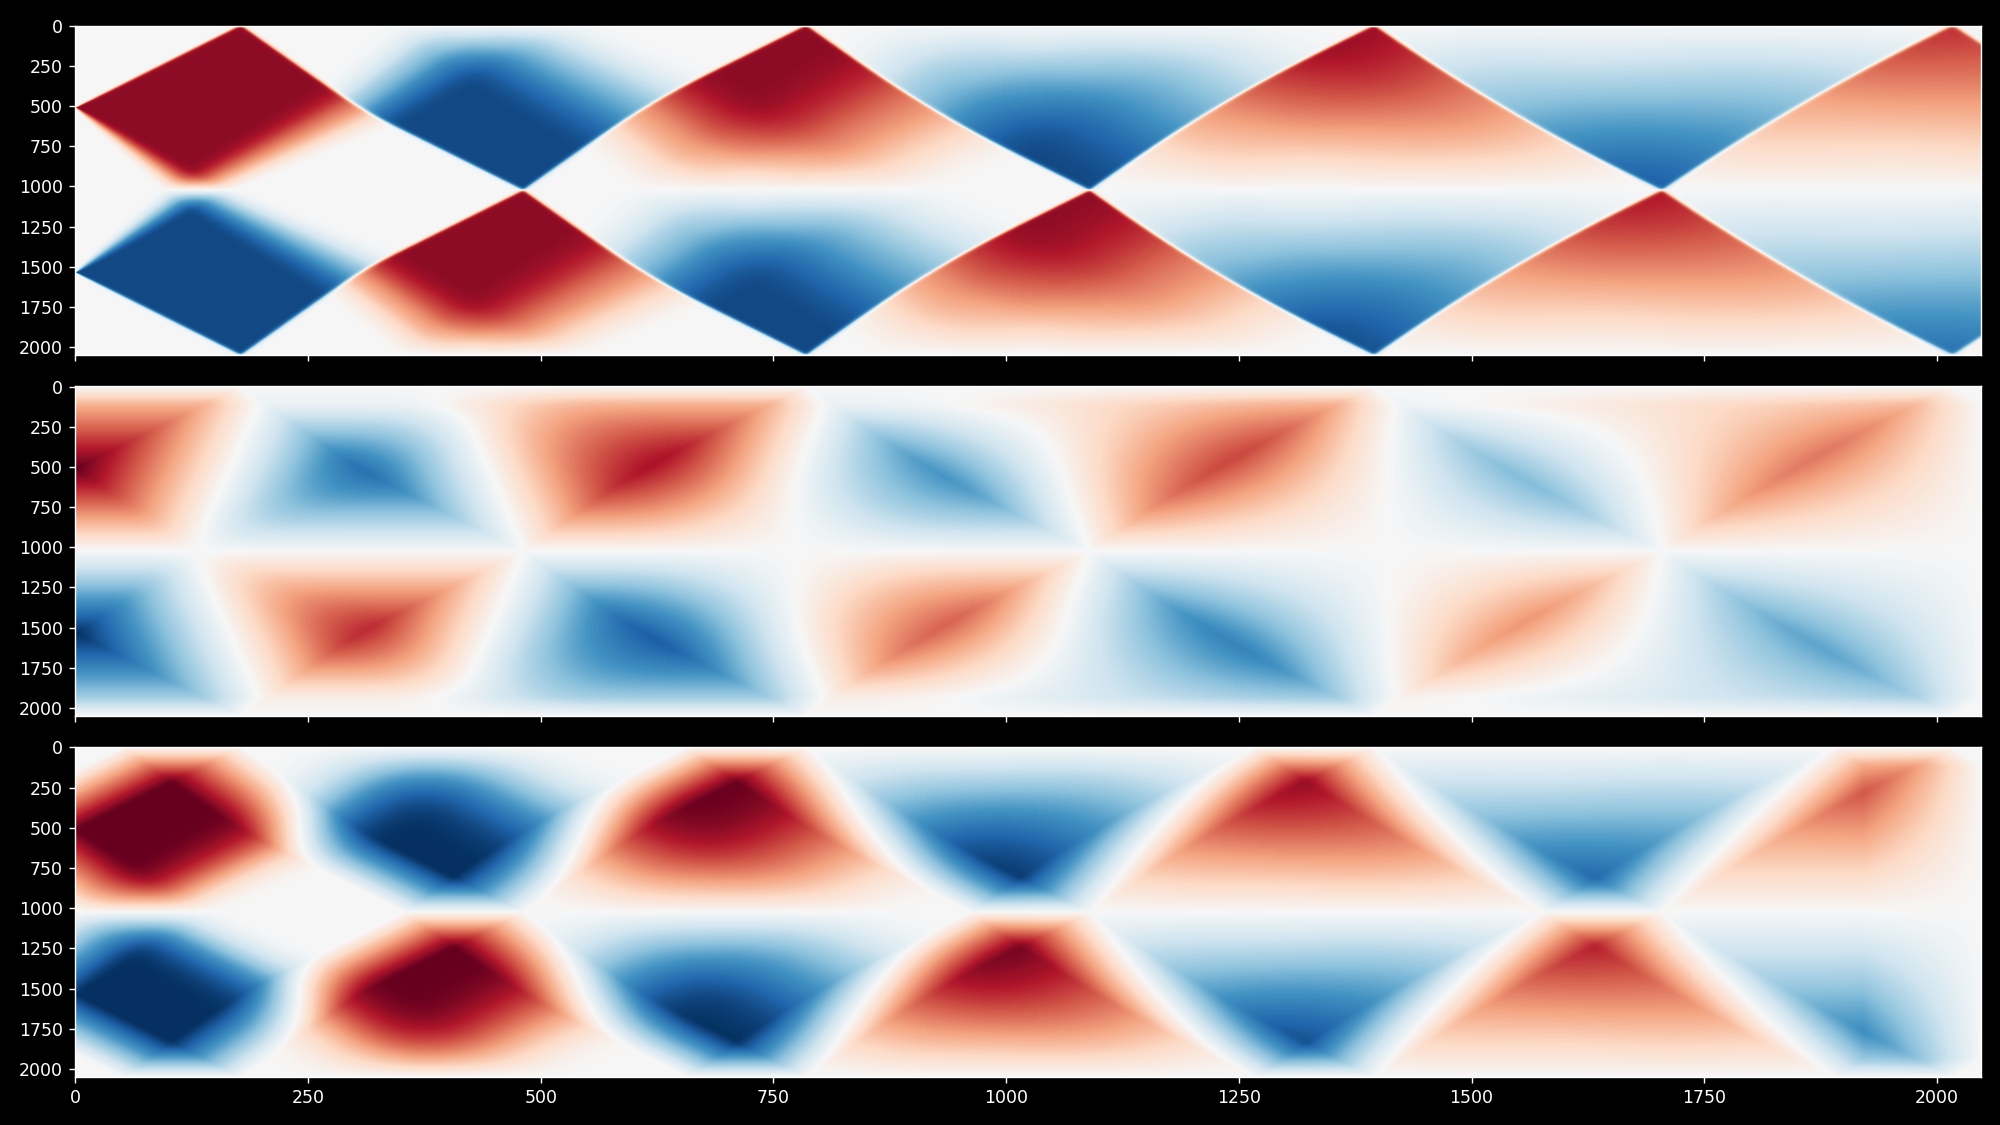

In [270]:
offset = 128

positions = simulationStates[:,0,:]
velocities = simulationStates[:,1,:]
accelerations = simulationStates[:,-2,:]
dx = dt * velocities + dt **2 * accelerations

x = dx.mT
cumsum = torch.cumsum(x, axis = 1)
s = torch.sum(x, axis = 1, keepdims=True)
r2lcumsum = x + s - cumsum
stacked = torch.hstack((r2lcumsum[:,:-offset] - r2lcumsum[:,offset:], r2lcumsum[:,-offset:]))

fig, axis = plt.subplots(3, 1, figsize=(16,9), sharex = True, sharey = False, squeeze = False)
axis[0,0].imshow(dx.mT, cmap = 'RdBu')
axis[0,0].axis('auto')

axis[1,0].imshow(r2lcumsum, cmap = 'RdBu')
axis[1,0].axis('auto')

axis[2,0].imshow(stacked, cmap = 'RdBu')
axis[2,0].axis('auto')

fig.tight_layout()

In [9]:
def processDataLoaderIter(pb, iterations, epoch, lr, dataLoader, dataIter, batchSize, model, optimizer, simulationStates, minDomain, maxDomain, particleSupport, lossFunction, getFeatures, getGroundTruth, stacked, train = True, prefix = '', augmentAngle = False, augmentJitter = False, jitterAmount = 0.01):
    with record_function("process data loader"): 
        losses = []
        batchIndices = []
        weights = []

        if train:
            model.train(True)
        else:
            model.train(False)

        i = 0
        for b in (pbl := tqdm(range(iterations), leave=False)):
            # get next batch from dataLoader, if all batches have been processed get a new iterator (which shuffles the batch order)
            try:
                bdata = next(dataIter)
                if len(bdata) < batchSize :
                    raise Exception('batch too short')
            except:
                dataIter = iter(dataLoader)
                bdata = next(dataIter)
            # the actual batch processing step
            with record_function("process data loader[batch]"): 
                # reset optimizer gradients
                if train:
                    optimizer.zero_grad()
                # load data for batch                
                stackedPositions, features, groundTruth, stackedNeighbors, d = loadBatch(simulationStates, minDomain, maxDomain, particleSupport, bdata, getFeatures, getGroundTruth, stacked)
                
                
                # run the network layer
                prediction = model((features[:,None], features[:,None]), stackedNeighbors, d)
                # compute the loss
                lossTerm = lossFunction(prediction, groundTruth)
                loss = torch.mean(lossTerm)
                # store the losses for later processing
                losses.append(lossTerm.detach().cpu().numpy())
                # store the current weights before the update
                weights.append(copy.deepcopy(model.state_dict()))
#                 if hasattr(model, 'weight'):
#                     weights.append(torch.clone(model.weight.detach().cpu()).numpy())
                # update the network weights
                if train:
                    loss.backward()
                    optimizer.step()
                # create some information to put on the tqdm progress bars
                batchString = str(np.array2string(np.array(bdata), formatter={'float_kind':lambda x: "%.2f" % x, 'int':lambda x:'%04d' % x}))
                pbl.set_description('%8s[gpu %d]: %3d [%1d] @ %1.1e: :  %s -> %.2e' %(prefix, 0, epoch, 0, lr, batchString, loss.detach().cpu().numpy()))
                pb.set_description('[gpu %d] %90s - Learning: %1.4e' %(0, "", np.mean(np.vstack(losses))))
                pb.update()
                batchIndices.append(bdata)
        # stack the processed batches and losses for further processing
        bIndices  = np.hstack(batchIndices)
#         losses = np.vstack(losses)
#         losses = np.vstack(losses)
        # and return
        return bIndices, losses, weights

In [10]:
ignoredTimesteps = 256
batchSize = 4 # training batch size
# Training done on all timesteps except the last ignoredTimesteps
timestamps = np.arange(0,simulationStates.shape[0] - ignoredTimesteps - offset)
testBatch = np.arange(len(simulationStates) - ignoredTimesteps -offset, len(simulationStates) - offset)

In [11]:
# create pytorch dataloader (via pytorch geometric for convenience)
dataLoader = DataLoader(timestamps, shuffle=True, batch_size = batchSize).batch_sampler
dataIter = iter(dataLoader)

In [12]:
def getGroundTruth(bdata, stacked, simulationStates):
    gt = [stacked[:,i] /dt for i in bdata] # Learning Physics Update
    gt = [simulationStates[i,2,:] for i in bdata] # Learning Density
    groundTruth = torch.hstack(gt)[:,None]
    return groundTruth

def getFeatures(stackedPositions, stackedAreas, stackedVelocities, stackedUpdates):
    features = torch.ones_like(stackedAreas)
    
    return features   

def lossFunction(prediction, groundTruth):
    return (prediction - groundTruth)**2 # MSE

In [352]:
# Hyperparameters for the NN
lr = 1e-1 # Learning rate
iterations = 1000 # update iterations per epoch
epochs = 10 # total number of epochs, LR is halved every epoch
n = 15 # number of weights per continuous convolution
basis = 'linear' # basis for the convolution, set to linear for CConv
computeBatchSize = 128 # higher number = faster processing but more memory consumption (not relevant for small simulations)
windowFn = getWindowFunction('Wendland2_1D') # window function that is applied after each network layer
windowFn = None # set to None for now
normalized = False # rbf normalization, can be safely ignored

<IPython.core.display.Javascript object>


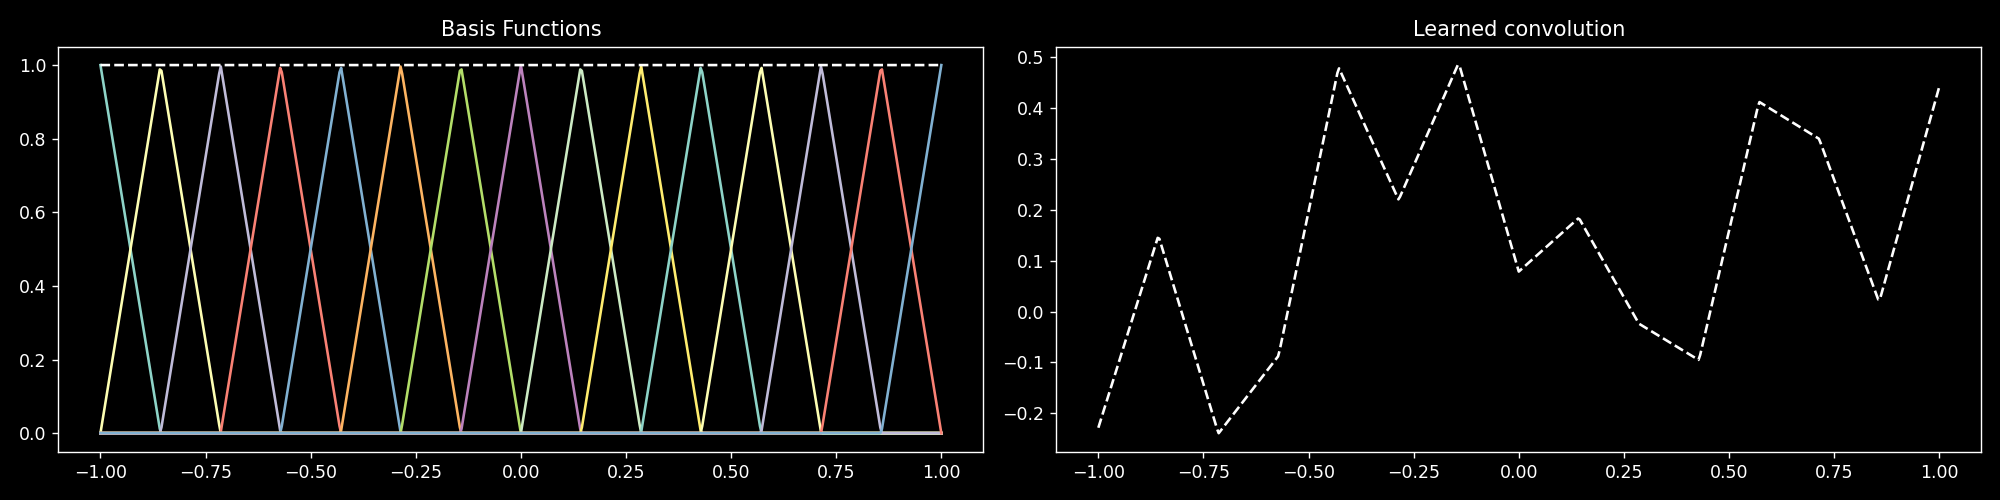

16

In [353]:
# Setup a single layer using the rbf convolution (which is a generalized CConv)
model = RbfConv(
            in_channels = 1, out_channels = 1,
                dim = 1, size = [n],
                rbf = basis,
                bias = True,
                linearLayer = False, biasOffset = False, feedThrough = False,
                preActivation = None, postActivation = None,
                coordinateMapping = 'cartesian',
                batch_size = [computeBatchSize, computeBatchSize], windowFn = windowFn, normalizeWeights = False, normalizeInterpolation = normalized)
# Adjusting the weight initialization for testing out things, defaults to uniform -0.05 to 0.05 as per the CConv paper
# torch.nn.init.uniform_(model.weight,0.0,0.3)
torch.nn.init.uniform_(model.weight,-.50,.50)
# Create optimizer for the single layer
optimizer = Adam(model.parameters(), lr=lr, weight_decay=0)
weightFn = lambda x: np.exp(-(x * 2.5)**2)
weightFn = getWindowFunction('Wendland2_1D')
# with torch.no_grad():    
#     model.weight[:,0,0] = torch.tensor(weightFn(np.linspace(-1,1,n)))
#     model.weight[:,0,0] = kernel(torch.abs(torch.linspace(-1,1,n)),1) * baseArea / particleSupport
plotWeights(model.state_dict(), basis, normalized)
count_parameters(model)

In [354]:
# n = 8
# basis = 'rbf square'
# randomWeights = []
# for i in range(128):
#     randomWeights.append(torch.rand(n) - 0.5)
# # randomWeights
# fig, axis = plt.subplots(1, 2, figsize=(16,4), sharex = False, sharey = False, squeeze = False)
# x =  torch.linspace(-1,1,511)
# # n = dict['weight'].shape[0]
# # internal function that is used for the rbf convolution
# fx = evalBasisFunction(n, x , which = basis, periodic=False)
# fx = fx / torch.sum(fx, axis = 0)[None,:] if normalized else fx # normalization step
# windowFn = getWindowFunction('Wendland2_1D') # window function that is applied after each network layer

# integrals = []
# for i in range(len(randomWeights)):
#     integral = torch.sum(torch.sum(randomWeights[i][:,None] * fx,axis=0)) * 2 / 511
#     integrals.append(integral)
# integrals = torch.hstack(integrals)
# norm = mpl.colors.Normalize(vmin=torch.min(integrals), vmax=torch.max(integrals))

# for i in range(len(randomWeights)):
#     axis[0,0].plot(x,torch.sum(randomWeights[i][:,None] * fx,axis=0),ls='-',c=cmap(norm(integrals[i])), label = '$\Sigma_i w_i f_i(x)$', alpha = 0.75)
#     axis[0,1].plot(x,windowFn(torch.abs(x)) * torch.sum(randomWeights[i][:,None] * fx,axis=0),ls='-',c=cmap(norm(integrals[i])), label = '$\Sigma_i w_i f_i(x)$', alpha = 0.75)
# # axis[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.20), ncol=5, fancybox=True, shadow=False)
# axis[0,0].set_title('Random initializations %s [%2d]'% (basis,n))
# axis[0,1].set_title('Random initializations %s [%2d] /w window'% (basis,n))

# fig.tight_layout()

In [355]:
# model.weight = torch.nn.Parameter((weights[-1][-1]['weight']).type(model.weight.dtype).to(model.weight.device))

In [366]:
b, l, w = processDataLoaderIter(pb, 1, epoch, lr, \
                                dataLoader, dataIter, batchSize, model, optimizer, \
                                simulationStates, minDomain, maxDomain, particleSupport, \
                                lossFunction, getFeatures, getGroundTruth, stacked,\
                                train = True, prefix = '', augmentAngle = False, augmentJitter = False, jitterAmount = 0.01)

  0%|          | 0/1 [00:00<?, ?it/s]

In [367]:
# print(loss)

In [368]:
currentWeights = model.weight
currentBias = model.bias

prediction = model((features[:,None], features[:,None]), stackedNeighbors, d)
lossTerm = lossFunction(prediction, groundTruth)
loss = torch.mean(lossTerm)
currentGrad = model.weight.grad
biasGrad = model.bias.grad

idealWeights = torch.clone(torch.hstack((kernel(torch.abs(torch.linspace(-1,1,n)),1) * baseArea / particleSupport,torch.tensor(0))))
idealDirection = torch.clone(idealWeights - torch.hstack((currentWeights[:,0,0], currentBias)).detach())
actualGradient = torch.clone(torch.hstack((currentGrad[:,0,0], biasGrad)))
normIdealDirection = torch.clone(idealDirection / torch.linalg.norm(idealDirection))
normCurrentDirection = torch.clone((actualGradient / torch.linalg.norm(actualGradient)))
center = torch.clone(torch.hstack((currentWeights[:,0,0], currentBias)).detach())

orthogonalDirection = normCurrentDirection - normIdealDirection.dot(normCurrentDirection) * normIdealDirection
orthogonalDirection = orthogonalDirection / torch.linalg.norm(orthogonalDirection)
print(normIdealDirection)
print(normCurrentDirection)
print(orthogonalDirection)
print(normCurrentDirection.dot(normIdealDirection), normCurrentDirection.dot(orthogonalDirection))
print(orthogonalDirection.dot(normIdealDirection), orthogonalDirection.dot(normCurrentDirection))
# startingWeights = 
# with torch.no_grad():    
#     model.weight[:,0,0] = torch.tensor(weightFn(np.linspace(-1,1,n)))
#     model.weight[:,0,0] = kernel(torch.abs(torch.linspace(-1,1,n)),1) * baseArea / particleSupport

tensor([ 0.0019, -0.0073,  0.2846,  0.3129, -0.2404, -0.2689, -0.4839, -0.2123,
         0.0187,  0.2985,  0.4927, -0.1249, -0.1961,  0.0110, -0.0054,  0.1588])
tensor([-1.5659e-05, -1.8992e-04, -1.8882e-04, -2.0045e-04, -2.0001e-04,
        -1.9053e-04, -1.9203e-04, -1.9991e-04, -1.9194e-04, -1.8964e-04,
        -2.0183e-04, -1.9828e-04, -1.8583e-04, -1.9181e-04, -1.2561e-05,
        -1.0000e+00])
tensor([ 2.9247e-04, -1.3661e-03,  4.5583e-02,  5.0134e-02, -3.8868e-02,
        -4.3453e-02, -7.8039e-02, -3.4356e-02,  2.8115e-03,  4.7816e-02,
         7.9057e-02, -2.0299e-02, -3.1727e-02,  1.5777e-03, -8.7715e-04,
        -9.8731e-01])
tensor(-0.1588) tensor(0.9873)
tensor(0.) tensor(0.9873)


In [369]:
with torch.no_grad():
    model.weight[:,0,0] = torch.nn.Parameter(center[:-1].type(model.weight.dtype).to(model.weight.device))
    model.bias = torch.nn.Parameter(center[-1].type(model.weight.dtype).to(model.weight.device))

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


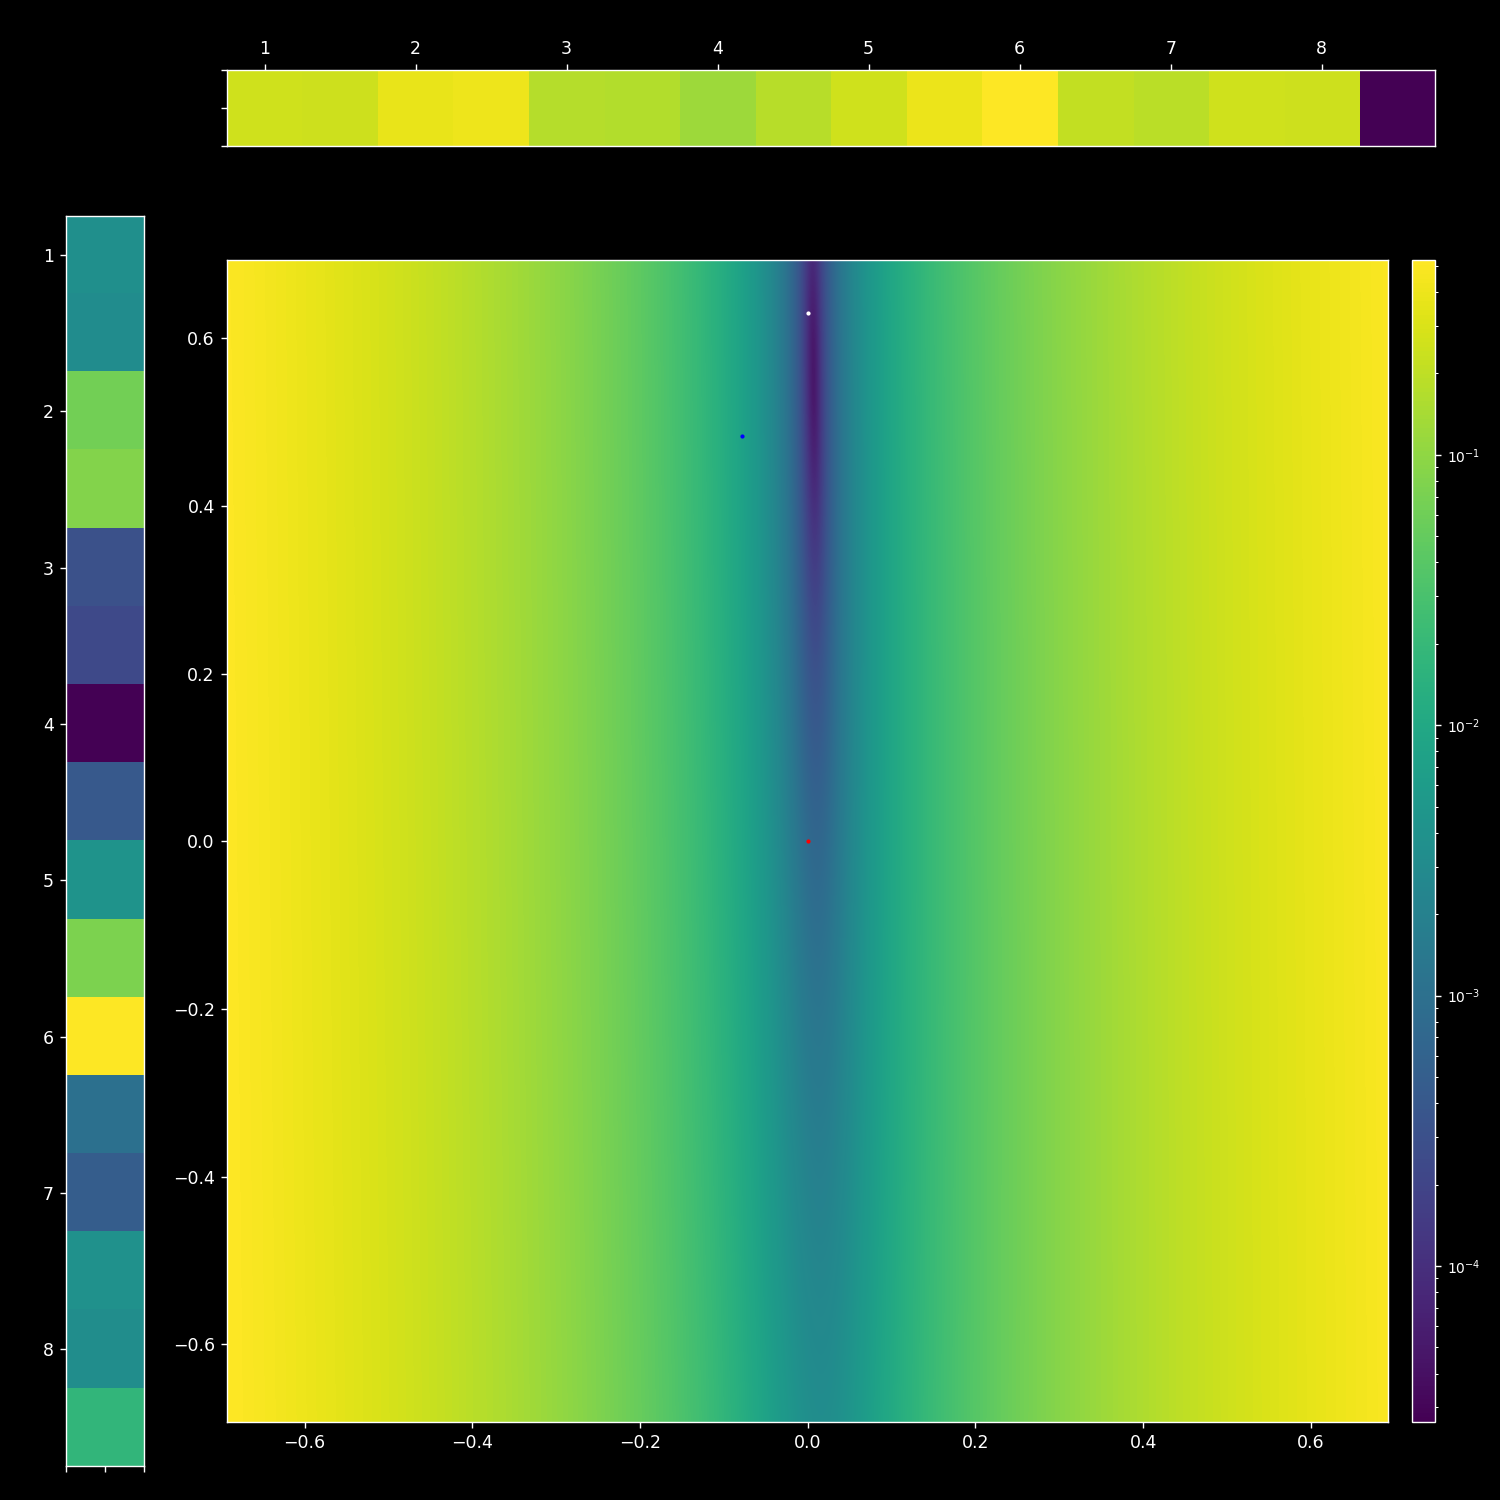

/tmp/ipykernel_158185/137844984.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[0,1].set_xticklabels(np.arange(n))
/tmp/ipykernel_158185/137844984.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[1,0].set_yticklabels(np.arange(n))


In [370]:
stackedPositions, features, groundTruth, stackedNeighbors, d = loadBatch(simulationStates, minDomain, maxDomain, particleSupport, np.arange(1), getFeatures, getGroundTruth, stacked)

limit = torch.linalg.norm(idealDirection) * 1.1
nx = 127
xExtent = [-limit,limit]
yExtent = [-limit,limit]
xs = np.linspace(xExtent[0],xExtent[1],nx)
ys = np.linspace(yExtent[0],yExtent[1],nx)
# ys = [0]
with torch.no_grad():
    model.weight[:,0,0] = torch.nn.Parameter(center[:-1].type(model.weight.dtype).to(model.weight.device))
    model.bias = torch.nn.Parameter(center[-1].type(model.weight.dtype).to(model.weight.device))
    
losses = []
for xi in tqdm(xs,leave = False):
    lossx = []
    for yi in tqdm(ys,leave = False):
        currentWeights = center + xi * orthogonalDirection + yi * normIdealDirection
        with torch.no_grad():
            model.weight[:,0,0] = torch.nn.Parameter(currentWeights[:-1].type(model.weight.dtype).to(model.weight.device))
            model.bias = torch.nn.Parameter(currentWeights[-1].type(model.weight.dtype).to(model.weight.device))
#             model.weight = torch.nn.Parameter(currentWeights.type(model.weight.dtype).to(model.weight.device))
            prediction = model((features[:,None], features[:,None]), stackedNeighbors, d)
            lossTerm = lossFunction(prediction, groundTruth)
            loss = torch.mean(lossTerm)
            lossx.append(loss)
        
    losses.append(np.hstack(lossx))
losses = np.vstack(losses)

with torch.no_grad():
    model.weight[:,0,0] = torch.nn.Parameter(center[:-1].type(model.weight.dtype).to(model.weight.device))
    model.bias = torch.nn.Parameter(center[-1].type(model.weight.dtype).to(model.weight.device))
    

fig, axis = plt.subplots(2,2, figsize=(12,12), sharex = False, sharey = False, squeeze = False, gridspec_kw={'width_ratios': [1, 7], 'height_ratios': [1, 7]})

axis[0,0].remove()
axis[0,1].imshow(orthogonalDirection[None,:])
axis[0,1].xaxis.tick_top()
axis[0,1].set_xticklabels(np.arange(n))
axis[0,1].set_yticklabels([])
axis[1,0].imshow(normIdealDirection[:,None])
axis[1,0].set_yticklabels(np.arange(n))
axis[1,0].set_xticklabels([])
im = axis[1,1].imshow(losses.transpose()[::-1,:],extent=[xExtent[0],xExtent[1],yExtent[0],yExtent[1]], norm=LogNorm(vmin=np.min(losses), vmax=np.max(losses)), interpolation = 'bicubic')
ax1_divider = make_axes_locatable(axis[1,1])
cax1 = ax1_divider.append_axes("right", size="2%", pad="2%")
cb1 = fig.colorbar(im, cax=cax1,orientation='vertical')
cb1.ax.tick_params(labelsize=8) 
axis[1,1].scatter(0,0, c = 'red', s = 2)

idealPoint = torch.linalg.norm(idealDirection)

curGradX = normIdealDirection.dot(normCurrentDirection) * limit / np.sqrt(2)
curGradY = orthogonalDirection.dot(normCurrentDirection) * limit / np.sqrt(2)

axis[1,1].scatter(0,idealPoint , c = 'white', s = 2)
axis[1,1].scatter(curGradX,curGradY , c = 'blue', s = 2)
fig.tight_layout()

<IPython.core.display.Javascript object>


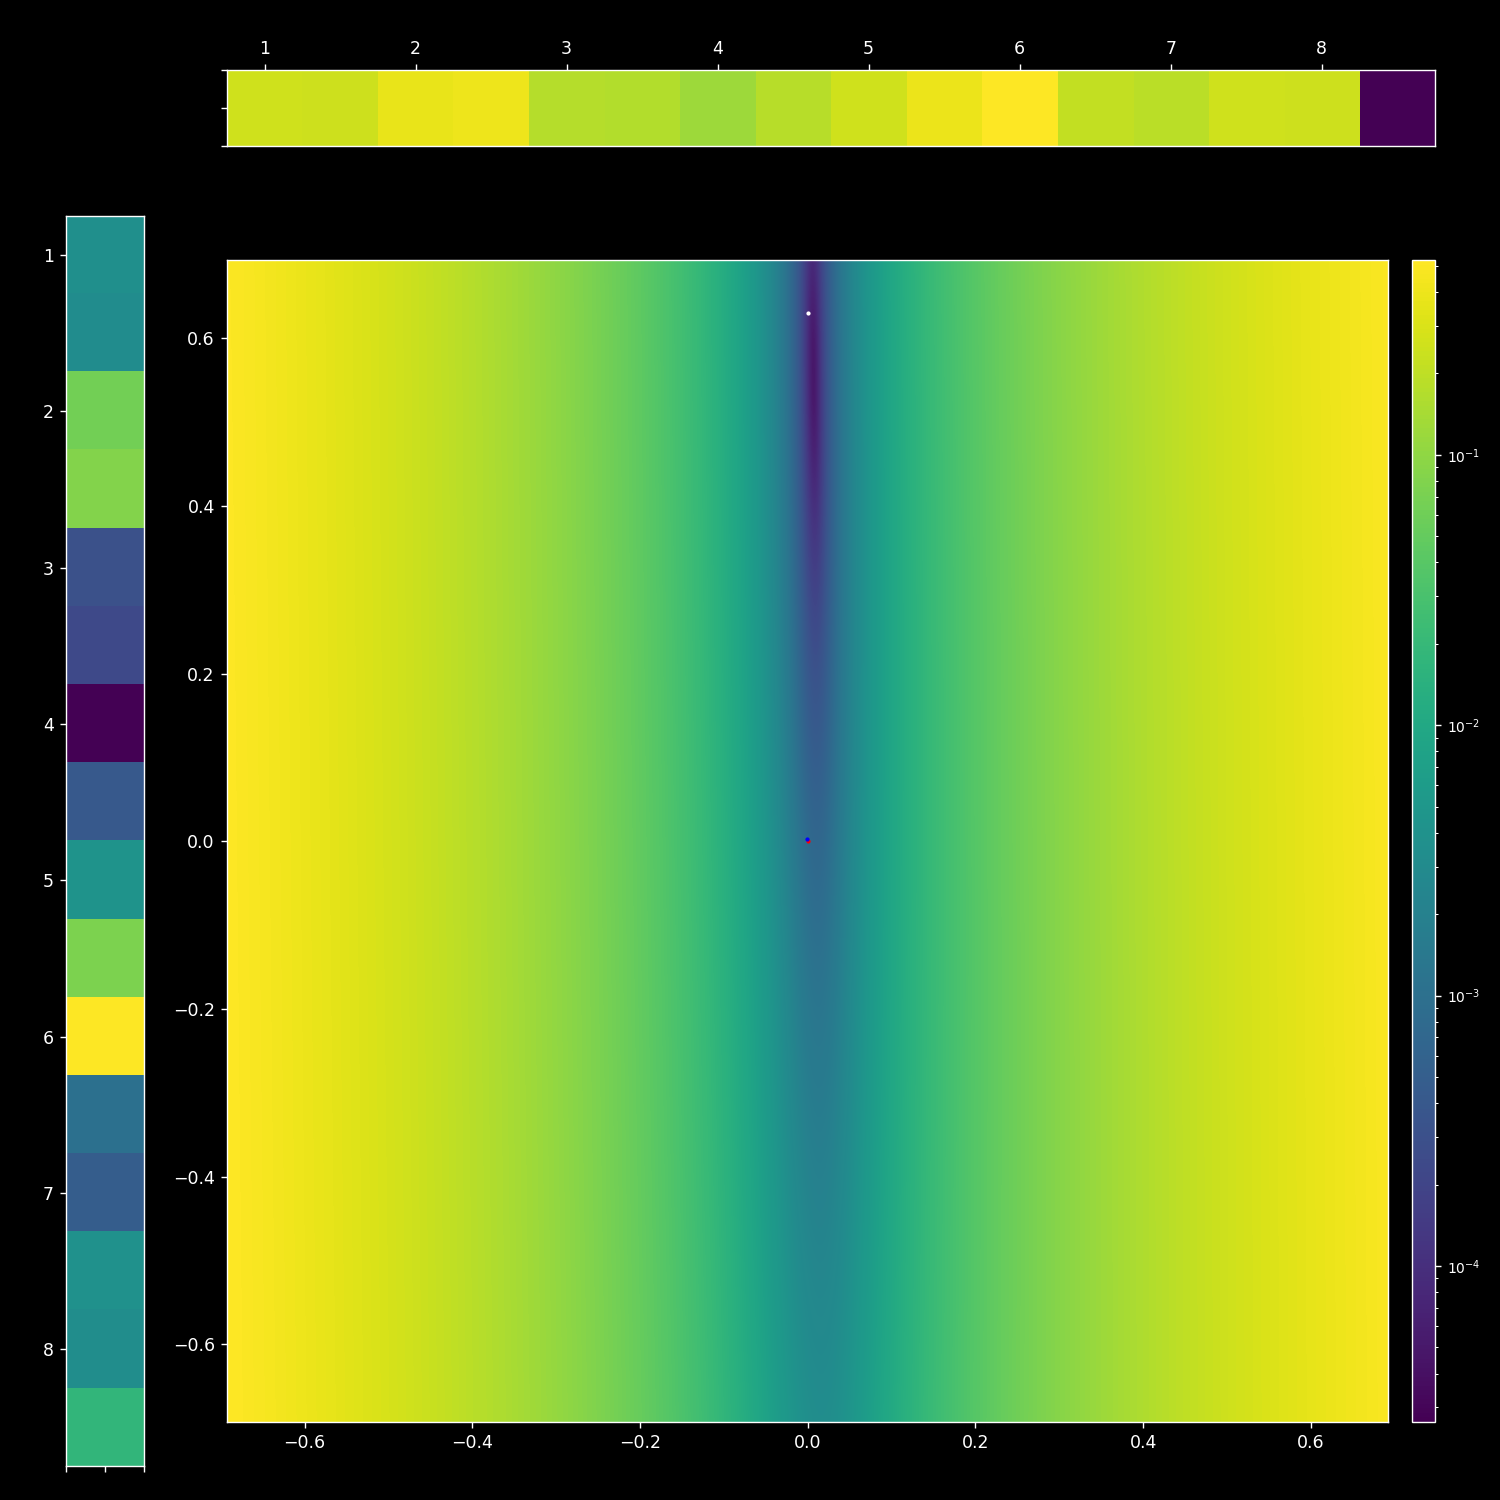

/tmp/ipykernel_158185/1639952508.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[0,1].set_xticklabels(np.arange(n))
/tmp/ipykernel_158185/1639952508.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[1,0].set_yticklabels(np.arange(n))


In [373]:

fig, axis = plt.subplots(2,2, figsize=(12,12), sharex = False, sharey = False, squeeze = False, gridspec_kw={'width_ratios': [1, 7], 'height_ratios': [1, 7]})

axis[0,0].remove()
axis[0,1].imshow(orthogonalDirection[None,:])
axis[0,1].xaxis.tick_top()
axis[0,1].set_xticklabels(np.arange(n))
axis[0,1].set_yticklabels([])
axis[1,0].imshow(normIdealDirection[:,None])
axis[1,0].set_yticklabels(np.arange(n))
axis[1,0].set_xticklabels([])
im = axis[1,1].imshow(losses.transpose()[::-1,:],extent=[xExtent[0],xExtent[1],yExtent[0],yExtent[1]], norm=LogNorm(vmin=np.min(losses), vmax=np.max(losses)), interpolation = 'bicubic')
ax1_divider = make_axes_locatable(axis[1,1])
cax1 = ax1_divider.append_axes("right", size="2%", pad="2%")
cb1 = fig.colorbar(im, cax=cax1,orientation='vertical')
cb1.ax.tick_params(labelsize=8) 
axis[1,1].scatter(0,0, c = 'red', s = 2)

idealPoint = torch.linalg.norm(idealDirection)

curGradX = normIdealDirection.dot(actualGradient) * lr #* limit / np.sqrt(2)
curGradY = orthogonalDirection.dot(actualGradient) * lr #* limit / np.sqrt(2)

axis[1,1].scatter(0,idealPoint , c = 'white', s = 2)
axis[1,1].scatter(curGradX,curGradY , c = 'blue', s = 2)
fig.tight_layout()

In [363]:

with torch.no_grad():
    model.weight[:,0,0] = torch.nn.Parameter(center[:-1].type(model.weight.dtype).to(model.weight.device))
    model.bias = torch.nn.Parameter(center[-1].type(model.weight.dtype).to(model.weight.device))
    
with torch.no_grad():
    model.weight[:,0,0] = torch.nn.Parameter(idealWeights[:-1].type(model.weight.dtype).to(model.weight.device))
    model.bias = torch.nn.Parameter(idealWeights[-1].type(model.weight.dtype).to(model.weight.device))
    prediction = model((features[:,None], features[:,None]), stackedNeighbors, d)
    lossTerm = lossFunction(prediction, groundTruth)
    loss = torch.mean(lossTerm)
    #             lossx.append(loss)
print('ideal loss:', loss)
    
with torch.no_grad():
    model.weight[:,0,0] = torch.nn.Parameter(center[:-1].type(model.weight.dtype).to(model.weight.device))
    model.bias = torch.nn.Parameter(center[-1].type(model.weight.dtype).to(model.weight.device))
    
with torch.no_grad():
#     model.weight[:,0,0] = torch.nn.Parameter(idealWeights[:-1].type(model.weight.dtype).to(model.weight.device))
#     model.bias = torch.nn.Parameter(idealWeights[-1].type(model.weight.dtype).to(model.weight.device))
    prediction = model((features[:,None], features[:,None]), stackedNeighbors, d)
    lossTerm = lossFunction(prediction, groundTruth)
    loss = torch.mean(lossTerm)
    #             lossx.append(loss)
print('current loss:', loss)


ideal loss: tensor(5.6343e-05, dtype=torch.float64)
current loss: tensor(2.6051, dtype=torch.float64)


In [364]:
# create progress bar and arrays to hold the learning progress
pb = tqdm(range(epochs * iterations))
lossArray = []
batches = []
weights = []
testing = []
# the actual learning process
for epoch in range(epochs):
    losses = []
    b, l, w = processDataLoaderIter(pb, iterations, epoch, lr, \
                                    dataLoader, dataIter, batchSize, model, optimizer, \
                                    simulationStates, minDomain, maxDomain, particleSupport, \
                                    lossFunction, getFeatures, getGroundTruth, stacked,\
                                    train = True, prefix = '', augmentAngle = False, augmentJitter = False, jitterAmount = 0.01)
    lossArray.append(l)
    batches.append(b)
    weights.append(w)
    if True: #epoch % 1 == 0 and epoch > 0:
        lr = lr * 0.5
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


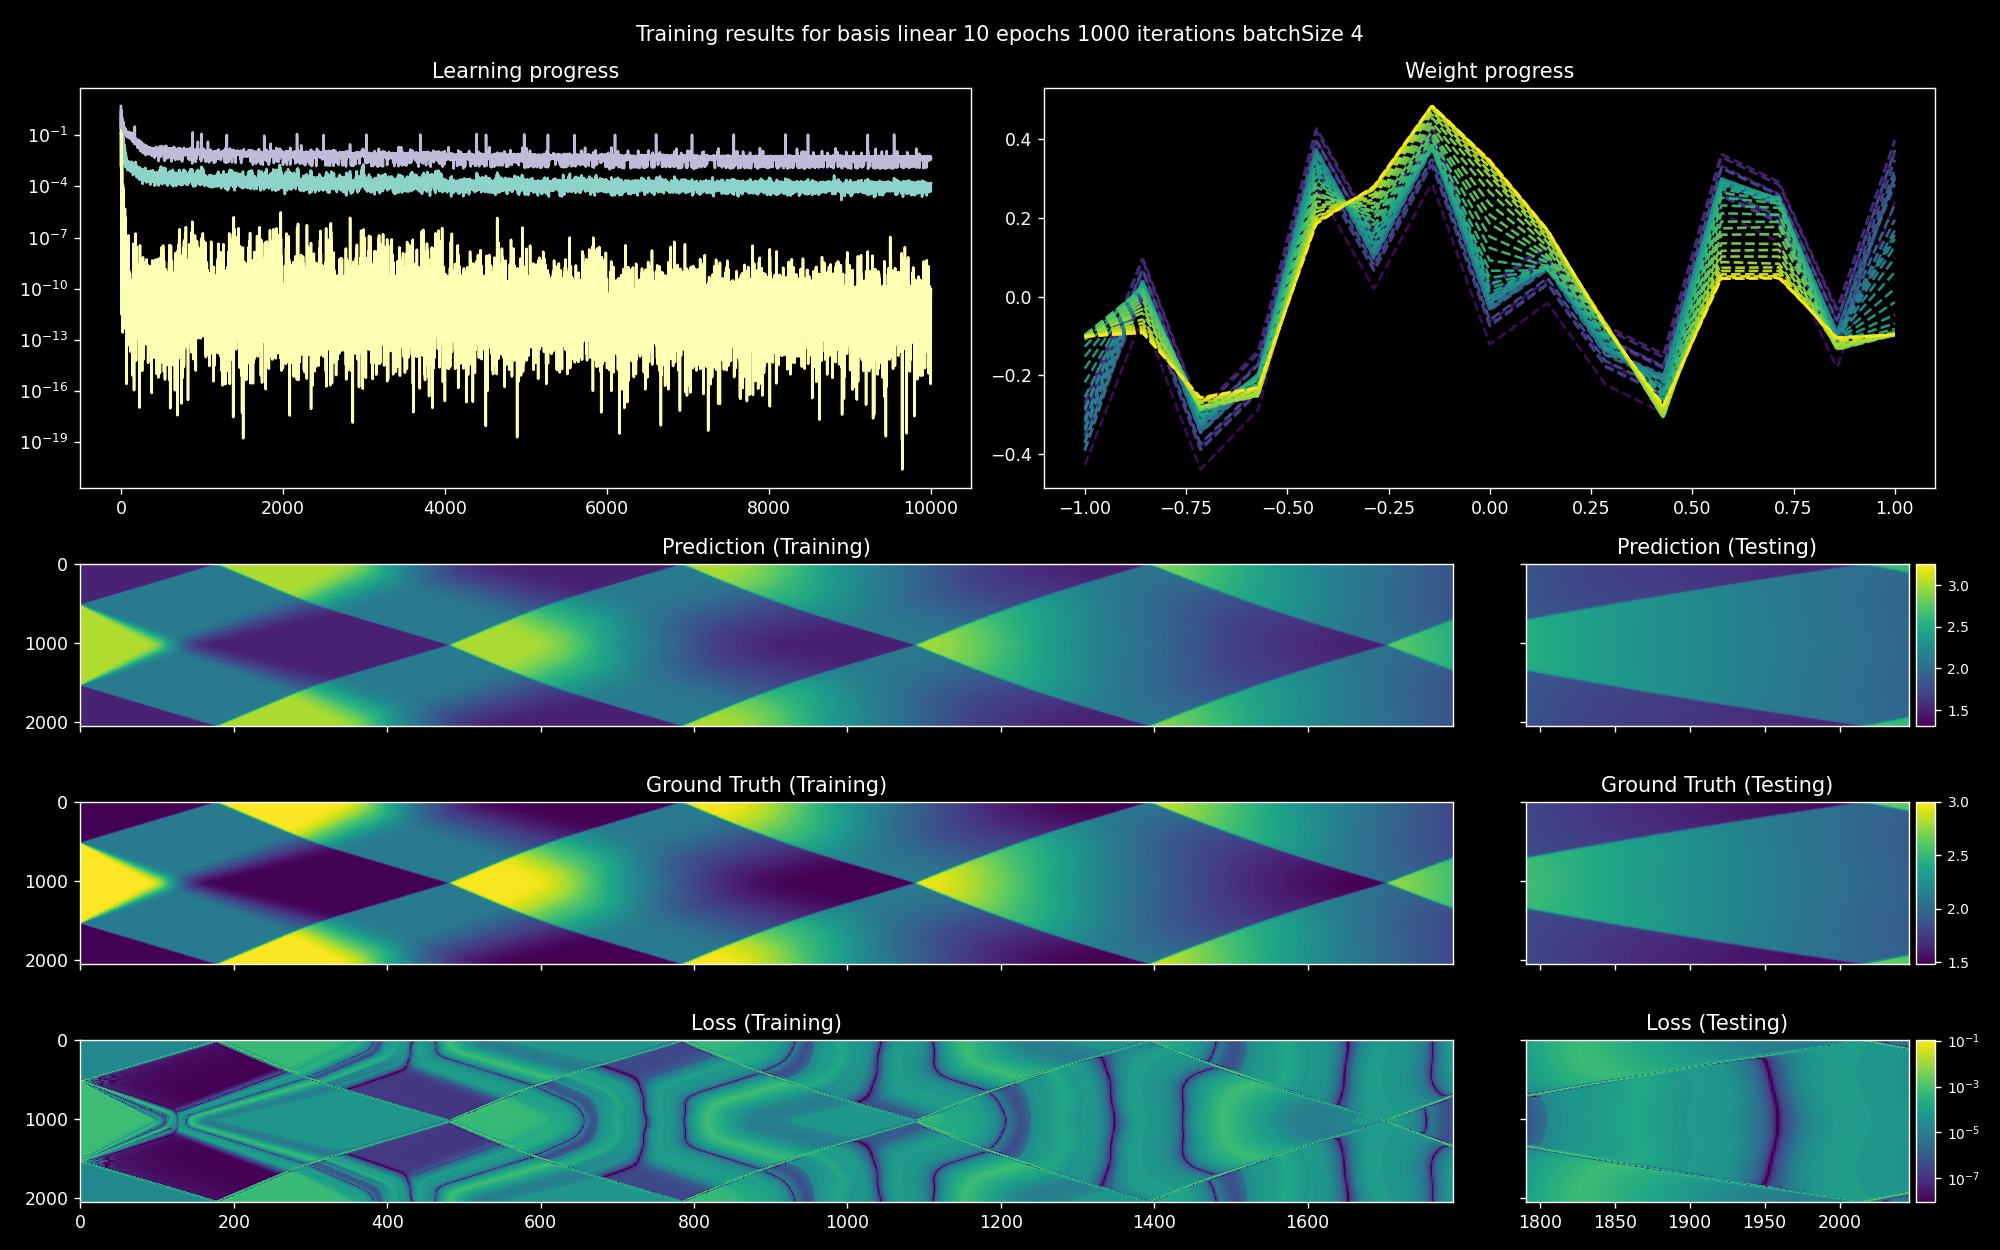

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [365]:
fig, axis = plotAll(model, weights, basis, normalized, iterations, epochs, numParticles, batchSize, lossArray, simulationStates, minDomain, maxDomain, particleSupport, timestamps, testBatch, lossFunction, getFeatures, getGroundTruth, stacked)
# plotTrainingAndTesting1Layer(model, lossArray, weights, basis, normalized, iterations, epochs, numParticles, batchSize, testBatch,lossFunction, simulationStates, minDomain, maxDomain, particleSupport, getFeatures, getGroundTruth, stacked)
# plotTraining1Layer(model, lossArray, weights, basis, normalized, iterations, epochs, numParticles, batchSize)
# plotBatchedLoss(model, weights[-1][-1], testBatch, lossFunction, simulationStates, numParticles, minDomain, maxDomain, particleSupport, getFeatures, getGroundTruth, stacked)
# _ = evalTestingAndTraining(model, weights[-1][-1], timestamps, testBatch, lossFunction, simulationStates, numParticles, minDomain, maxDomain, particleSupport, getFeatures, getGroundTruth, stacked, plot = True)

<IPython.core.display.Javascript object>


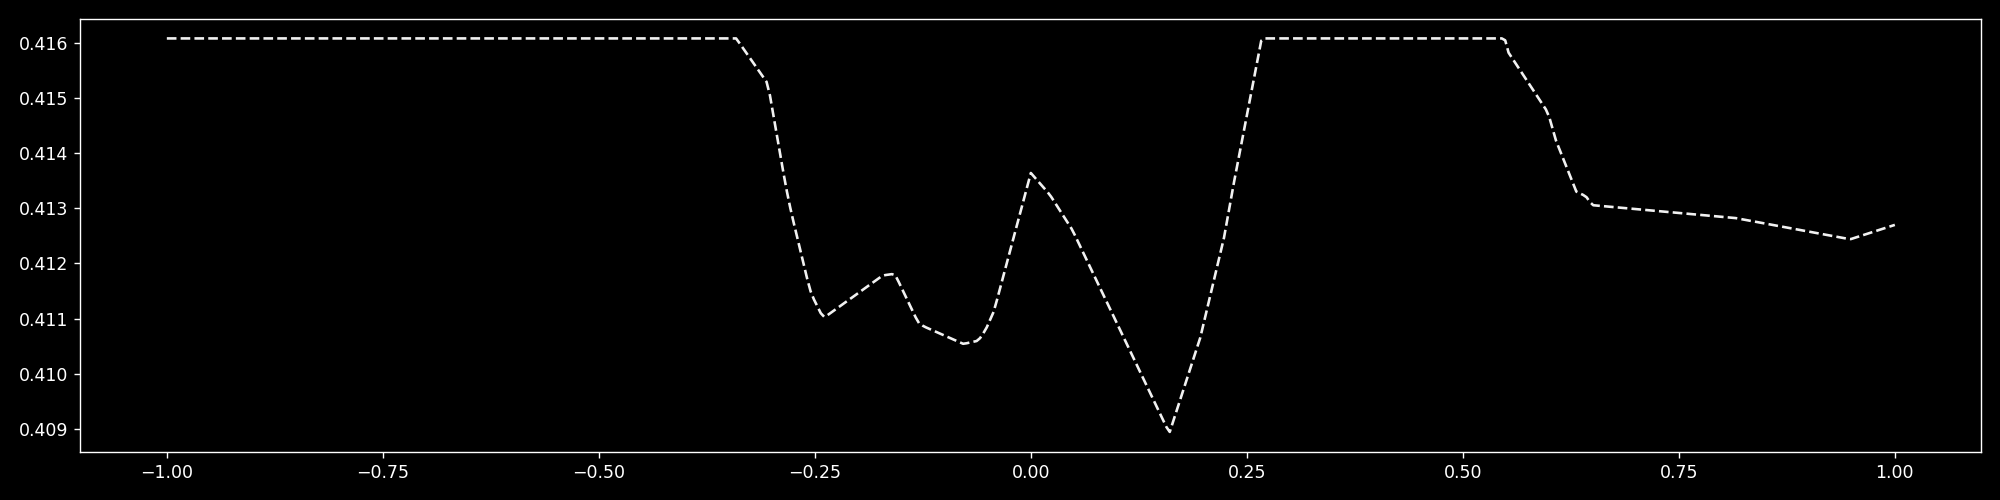

461

In [18]:
# Hyperparameters for the NN
lr = 1e-1 # Learning rate
iterations = 100 # update iterations per epoch
epochs = 10 # total number of epochs, LR is halved every epoch
n = 32 # number of weights per continuous convolution
basis = 'linear' # basis for the convolution, set to linear for CConv
computeBatchSize = 128 # higher number = faster processing but more memory consumption (not relevant for small simulations)
windowFn = getWindowFunction('Wendland2_1D') # window function that is applied after each network layer
windowFn = None # set to None for now
normalized = False # rbf normalization, can be safely ignored
class network(nn.Module):
    def __init__(self, layers = [8,8,4,1]):
        super(network, self).__init__()
        modules = []
        for i in range(len(layers)):
            modules.append(nn.Linear(1 if i == 0 else layers[i-1],layers[i]))
            modules.append(nn.BatchNorm1d(layers[i]))
            modules.append(nn.ReLU())
        modules.append(nn.Linear(layers[-1],1))
        self.proc = nn.Sequential(*modules)
        
    def forward(self, features, neighbors, distances):  # Input is a 1D tensor
        fi, fj = features
        edges = self.proc(distances)
        i, j = neighbors
        out = scatter(fj[j] * edges, i, dim = 0, dim_size = fi.shape[0], reduce = 'sum')
        return out
        
MLPmodel = network([8,8,16,8,1])
optimizerMLP = Adam(MLPmodel.parameters(), lr=lr, weight_decay=0)
plotMLP(MLPmodel, MLPmodel.state_dict())
count_parameters(MLPmodel)

In [19]:
# create progress bar and arrays to hold the learning progress
pb = tqdm(range(epochs * iterations))
mlp_lossArray = []
mlp_batches = []
mlp_weights = []
mlp_testing = []
# the actual learning process
for epoch in range(epochs):
    losses = []
    b, l, w = processDataLoaderIter(pb, iterations, epoch, lr, \
                                    dataLoader, dataIter, batchSize, MLPmodel, optimizerMLP, \
                                    simulationStates, minDomain, maxDomain, particleSupport, \
                                    lossFunction, getFeatures, getGroundTruth, stacked,\
                                    train = True, prefix = '', augmentAngle = False, augmentJitter = False, jitterAmount = 0.01)
    mlp_lossArray.append(l)
    mlp_batches.append(b)
    mlp_weights.append(w)
    if epoch % 2 == 0 and epoch > 0:
        lr = lr * 0.5
        for param_group in optimizerMLP.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


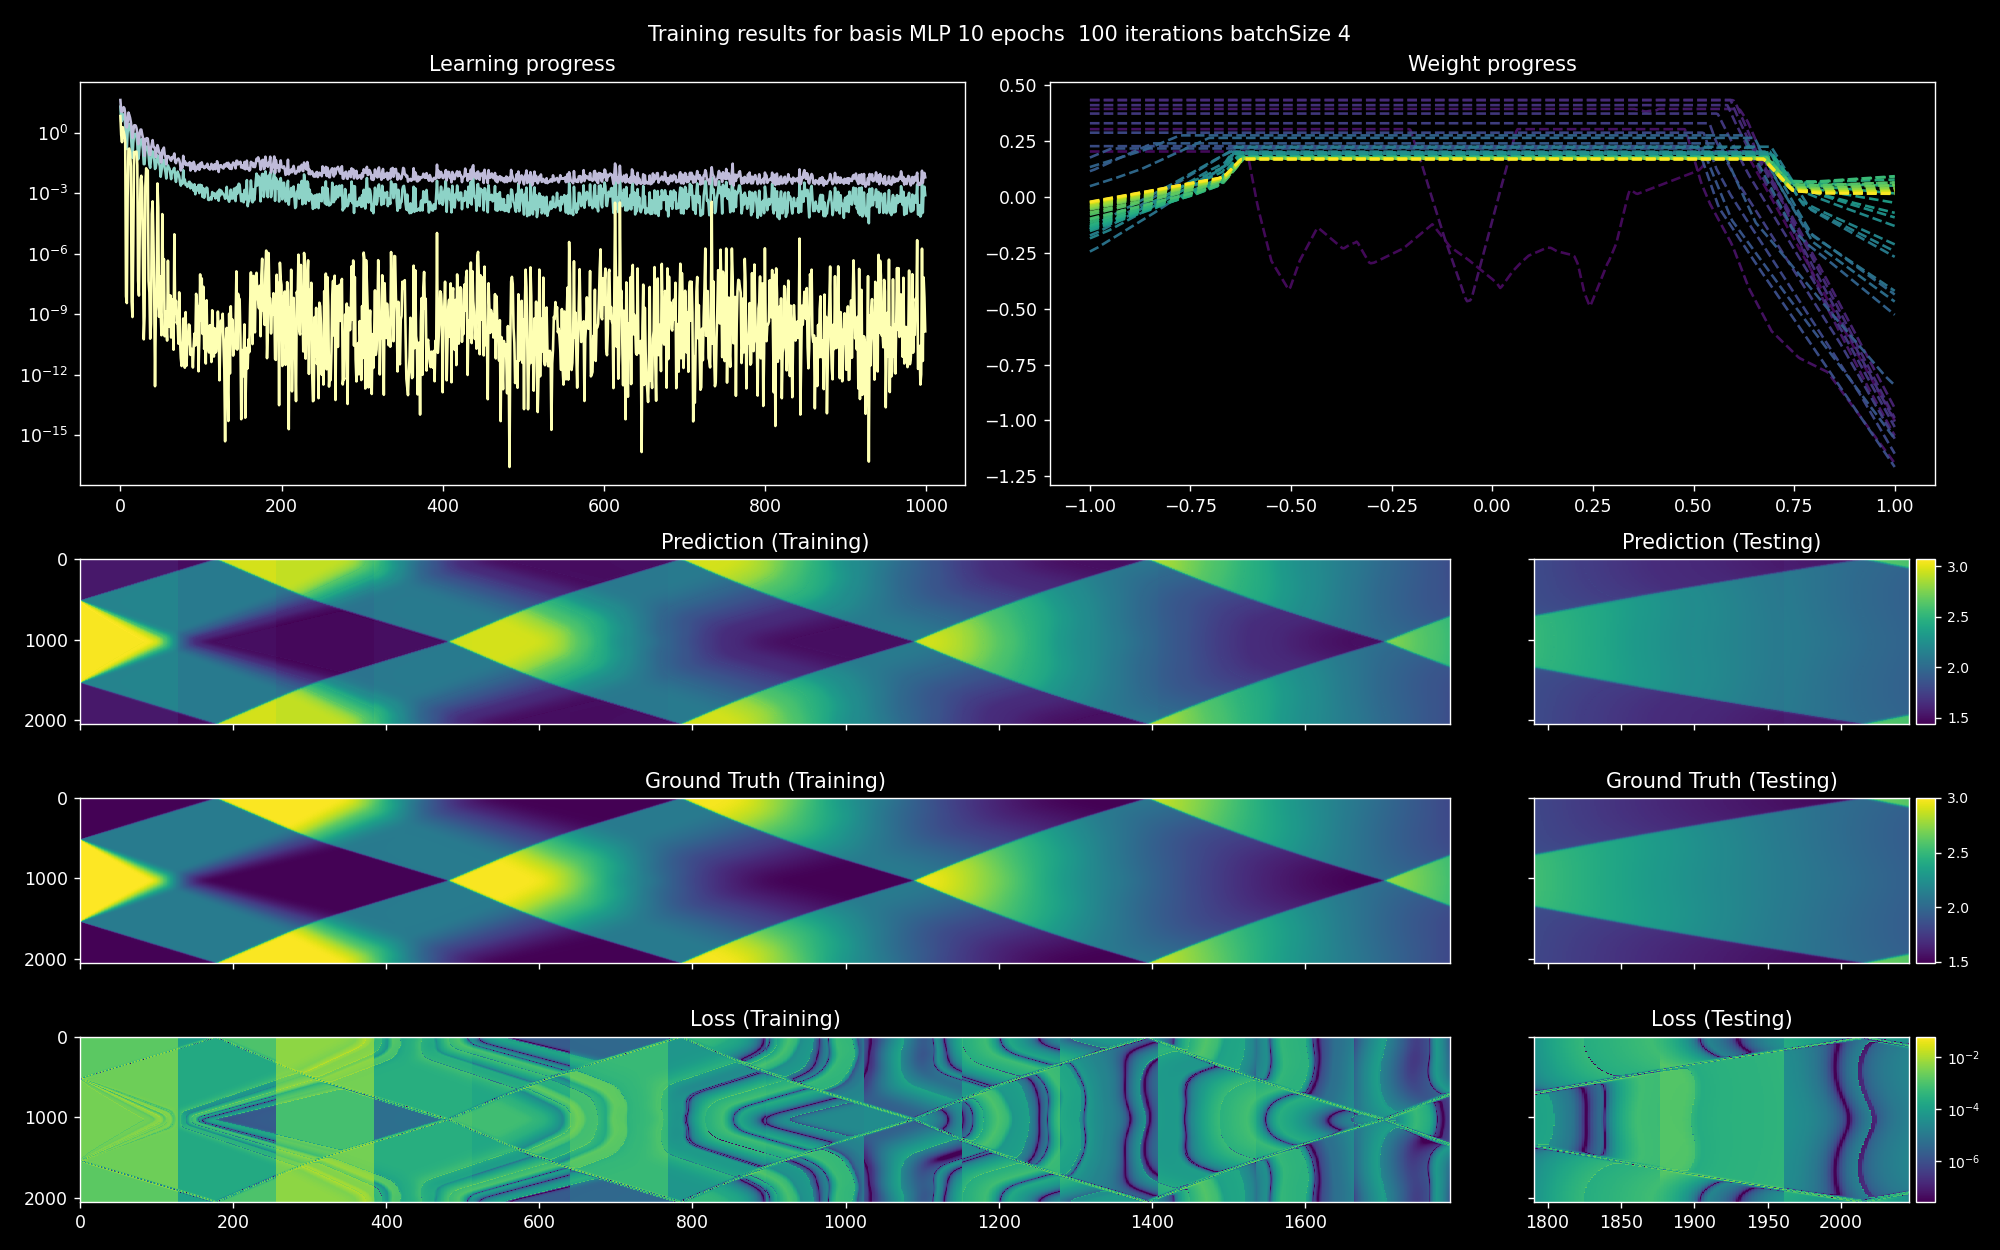

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

(<Figure size 1600x1000 with 11 Axes>,
 {'A': <AxesSubplot:label='A', title={'center':'Learning progress'}>,
  'B': <AxesSubplot:label='B', title={'center':'Weight progress'}>,
  'C': <AxesSubplot:label='C', title={'center':'Prediction (Training)'}>,
  'D': <AxesSubplot:label='D', title={'center':'Prediction (Testing)'}>,
  'E': <AxesSubplot:label='E', title={'center':'Ground Truth (Training)'}>,
  'F': <AxesSubplot:label='F', title={'center':'Ground Truth (Testing)'}>,
  'G': <AxesSubplot:label='G', title={'center':'Loss (Training)'}>,
  'H': <AxesSubplot:label='H', title={'center':'Loss (Testing)'}>})

In [85]:
plotAll(MLPmodel, mlp_weights, 'MLP', normalized, iterations, epochs, numParticles, batchSize, mlp_lossArray, simulationStates, minDomain, maxDomain, particleSupport, timestamps, testBatch, lossFunction, getFeatures, getGroundTruth, stacked)